<a href="https://colab.research.google.com/github/neerajguleria1/driver-drowsiness-detection/blob/main/ml_pipeline_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Speed  Seatbelt  Alertness  Heart_rate  Fatigue  Drowsy
0     94         1   0.531937          94        6       1
1    108         0   0.692850          78        3       0
2    110         1   0.248338          97       10       1
3     78         0   0.359349          99        7       0
4     99         1   0.681798          65        4       0
(2000, 6)
Accuracy: 70.83%
Precision: 63.29%
Recall: 56.96%
F1 Score: 59.95%


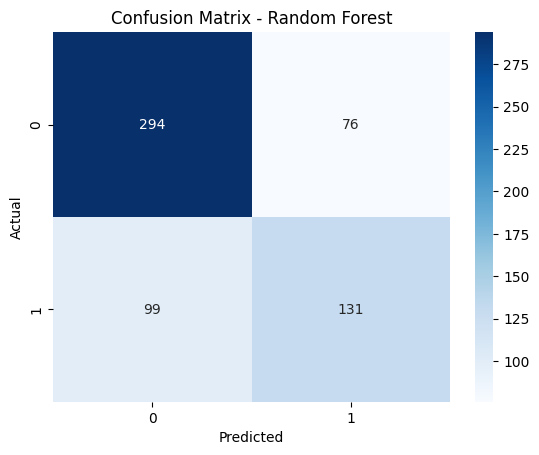

CV Scores: [0.685  0.685  0.705  0.6975 0.67  ]
Mean Score: 68.85 %
Std Dev: 1.2 %


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score,recall_score,f1_score

# 1. Generate synthetic dataset
n = 2000
np.random.seed(42)

# Fatigue (0–10) drives everything
fatigue = np.random.randint(0, 11, n)

# Alertness decreases with fatigue
alertness = np.clip(
    1 - (fatigue / 12) + np.random.normal(0, 0.05, n),
    0.05,
    1.0
)

# Heart rate increases with fatigue + decreases with alertness
heart_rate = np.random.normal(
    80 + fatigue * 2 - alertness * 5,
    10,
    n
).clip(50, 150)

# Speed decreases with fatigue
speed = np.random.normal(
    120 - fatigue * 3,
    30,
    n
).clip(30, 250).astype(int)

# Seatbelt usage
seatbelt = np.random.choice([0,1], size=n, p=[0.3, 0.7])

# -------------------------------
# 2. True drowsiness probability
# -------------------------------
drowsy_prob = (
      0.45 * (1 - alertness)     # low alertness is main factor
    + 0.40 * (fatigue / 10)      # high fatigue strongly increases risk
    + 0.10 * (heart_rate > 100)  # high HR indicates stress/drowsiness
    + 0.05 * (speed < 60)        # slow speed often means sleepy
)

drowsy_prob = drowsy_prob.clip(0, 1)

# Convert prob → label
drowsy = np.random.binomial(1, drowsy_prob)

# 3. Create dataframe
df = pd.DataFrame({
    "Speed": speed,
    "Seatbelt": seatbelt,
    "Alertness": alertness,
    "Heart_rate": heart_rate.astype(int),
    "Fatigue": fatigue,
    "Drowsy": drowsy
})

print(df.head())
print(df.shape)

df.to_csv("driver_drowsiness_detection.csv", index=False)

# 4. Train/Test Split
X = df[["Speed", "Alertness", "Seatbelt", "Heart_rate", "Fatigue"]]
y = df["Drowsy"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 5. Train Model
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 6. Evaluate

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall: {rec*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 7. Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")

print("CV Scores:", cv_score)
print("Mean Score:", round(cv_score.mean()*100, 2), "%")
print("Std Dev:", round(cv_score.std()*100, 2), "%")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Speed       2000 non-null   int64  
 1   Seatbelt    2000 non-null   int64  
 2   Alertness   2000 non-null   float64
 3   Heart_rate  2000 non-null   int64  
 4   Fatigue     2000 non-null   int64  
 5   Drowsy      2000 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 93.9 KB
None
Speed         0
Seatbelt      0
Alertness     0
Heart_rate    0
Fatigue       0
Drowsy        0
dtype: int64


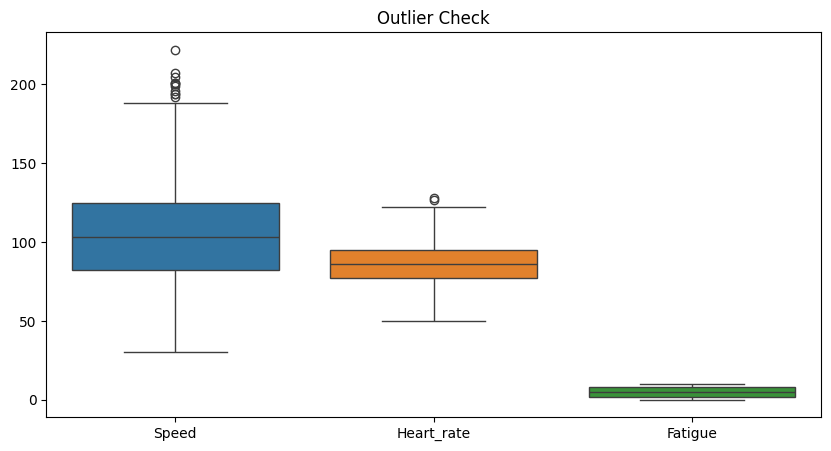

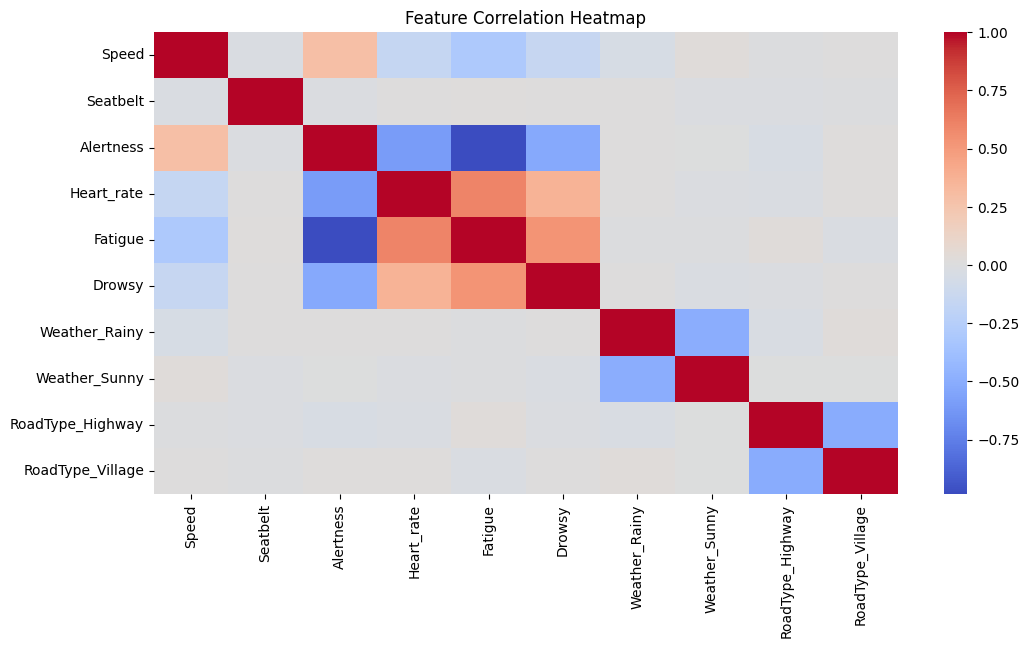

Accuracy: 71.67
            Feature  Importance
2         Alertness    0.360526
3        Heart_rate    0.197937
0             Speed    0.183790
4           Fatigue    0.145512
1          Seatbelt    0.024960
6     Weather_Sunny    0.023281
5     Weather_Rainy    0.023008
7  RoadType_Highway    0.020535
8  RoadType_Village    0.020451


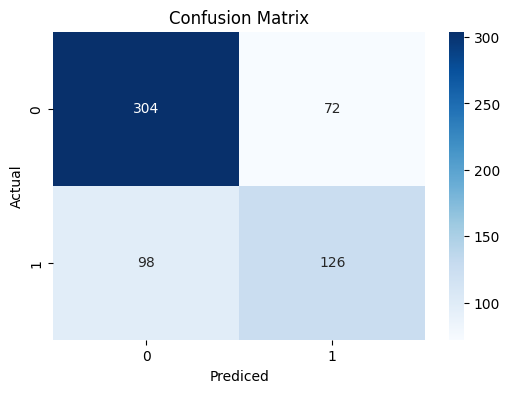

Cross-Validation Scores: [0.7025 0.69   0.7175 0.69   0.69  ]
Mean Accuracay: 69.8 %
Std Deviation: 1.09 %


In [7]:
# Day 26
''' Today we perform Scaling like standardScaler, MinMaxScaler
Endcoding: OneHotEncoding, LabelEncoding
Feature Selection: Correlation, Importance Ranking
Outlier Detection
Pipeline
Today after this our model becomes faster, more accurate and more stable'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

df=pd.read_csv("driver_drowsiness_detection.csv")

# Now we check data types
print(df.info()) # it show data types and its very important for scaling and encoding
print(df.isnull().sum()) # and this one shows missing values

# In this we handle missing values
''' why we do this, if our dataset has no missing values
but we have must always write missig value handlin code.
Because in real world projects, data is never clean.'''

df=df.fillna(df.mean(numeric_only=True))

# Now the most important thing we do like real engineer do
''' Outlier Detection & Handling : Out synthetic dataset can still contain
extreme values because of the distribution. We need to fix them.

# Our 4 step is Visualize Outlier with Boxplots '''
plt.figure(figsize=(10,5))
sns.boxplot(data=df[['Speed','Heart_rate','Fatigue']])
plt.title("Outlier Check")
plt.show()
''' Why this matters:
    Outliers Destroy ML model Stability
    We see extreme spikes visually
    Boxplot is the fastest way to detect them
    Helps us to debug quality '''


# Step 5 is Handle Oulier
''' Now we clip extreme values in outlier range'''
df['Speed']=np.clip(df['Speed'],30,250)
df['Heart_rate']=np.clip(df['Heart_rate'],50,140)

# Step 6 Now we Add Categorial Feature
df['Weather']=np.random.choice(['Sunny','Rainy','Foggy'],size=len(df))
df['RoadType']=np.random.choice(['Highway','City','Village'],size=len(df))
''' Weather affects: Foggy: higher drowsy chance, Rainy: more stress
RoadType: Highway: Higher Speed, City: more stop & go,  Village: Uneven Roads'''


# Step 7 One Hot Encode the Categorical Feature
df_encoded=pd.get_dummies(df,columns=['Weather','RoadType'],drop_first=True)
''' drop_first=True is used for avoid dummy varuiable trap'''


# Step 8 Feature Correlation Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df_encoded.corr(),cmap="coolwarm",annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Step 9 Now we Extract Features and target
''' Our encoded dataset now has Many columns, including:
numerical features, one-hot encoded weather,one-hot encoded road type and target column
we have to seprate them cleanly'''
X=df_encoded.drop('Drowsy',axis=1)
y=df_encoded['Drowsy']
''' ML modes need X(featues) and y(labels), dropping drowsy prevent leakage
all encoded columns are included automatically and now this prepares our dataset for training'''

# Step 10 In this we Split the data for training and testing
X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.3,random_state=42
)

# Step 11 We Build a Machine Learnin Pipeline
'''  A Pipeline is how real-world ML system are written
It ensures: clean preprocessing, Automatic Scaling, Autmatic model training
Now messy code, no manual mistake  and ready for deployment
We will use: StandardScaler for scaling and RandomForestClassifier for prediction'''

from sklearn.pipeline import Pipeline
pipeline=Pipeline([
    ('scaler',StandardScaler()),
    ('model',RandomForestClassifier(n_estimators=200,random_state=42))
])
''' This scaler is only applied only to training data , and same is used to automatically
on test data, eveything becomes modular and clean, future model changes becomes super easy'''

# Step 12 Now we train the pipeline
''' Now we fit the pipeline on our training data.
This will : scale the data, train the randomForest, and stores everyting a single clean pipeline'''
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)
''' When we run pipeline.fit():
StandardScaler learns the scaling from X_train and X_train get scales and RandomForstTrain in scaled on X_train
And when we run pipeline.predict():
StandardScaler scales X_test (using same stats from training)
RandmoForst predict on scaled X_test'''

# Step 13 Now we Evalute Model Performance
accuracy=accuracy_score(y_test,y_pred)
print(f"Accuracy: {accuracy*100:.2f}")

# Step 24 Feature Importance
''' Pipeline hideds the model inside, so we extract like this:'''
importances=pipeline.named_steps['model'].feature_importances_

feature_importances=pd.DataFrame({
    'Feature':X_train.columns,
    'Importance':importances
}).sort_values(by='Importance',ascending=False)
print(feature_importances)

# Step 15  Confusion Matrix

cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Prediced")
plt.ylabel("Actual")
plt.show()

# Step 16 K-Fold  Cross Validation
'''KFold split data into 5 folds, cross_val_score train and tests 5 times
accuracay as performane metrics'''
from sklearn.model_selection import KFold,cross_val_score
kfold=KFold(n_splits=5,shuffle=True, random_state=42)
cv_scores=cross_val_score(pipeline,X,y,cv=kfold,scoring='accuracy')
print("Cross-Validation Scores:",cv_scores)
print("Mean Accuracay:",round(cv_scores.mean()*100,2),"%")
print("Std Deviation:",round(cv_scores.std()*100,2),"%")


Accurracy 0.7216666666666667
Precision 0.6144578313253012
Recall 0.6830357142857143
F1 0.6469344608879493
ROC-AUC 0.7138582826747721

Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       376
           1       0.61      0.68      0.65       224

    accuracy                           0.72       600
   macro avg       0.71      0.71      0.71       600
weighted avg       0.73      0.72      0.72       600



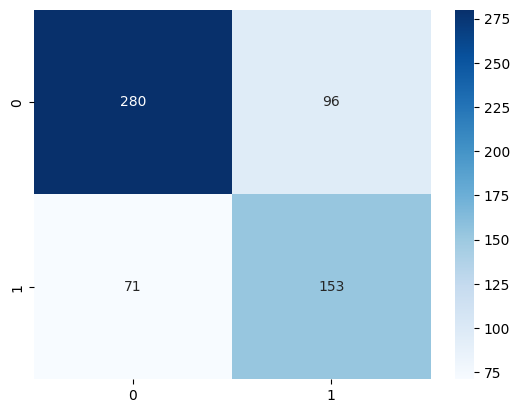

Model saved successfully


In [19]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

import joblib
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("driver_drowsiness_detection.csv")
new_data = pd.DataFrame([{
    "Eye": 0.30,
    "BlinkRate": 18,
    "HeartRate": 80,
    "Heart_rate": 82,
    "Fatigue": 4,
    "Alertness": 0.6,
    "Speed": 60,
    "Seatbelt": 1,
    "Weather": "Sunny",
    "RoadType": "Highway"
}])

df['Weather'] = np.random.choice(['Sunny','Rainy','Foggy'], size=len(df))
df['RoadType'] = np.random.choice(['Highway','City','Village'], size=len(df))

target="Drowsy"

categorical_cols=["Weather","RoadType"]
numerical_cols=[col for col in df.columns if col not in categorical_cols+[target]]

preprocess=ColumnTransformer(
    transformers=[
        ("num",StandardScaler(),numerical_cols),
        ("cat",OneHotEncoder(drop='first'),categorical_cols)
    ]
)

final_pipeline=ImbPipeline(steps=[
    ('preprocess',preprocess),
    ('smote',SMOTE(random_state=42)),
    ('model',RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        class_weight='balanced',
        random_state=42
    ))
])

X=df.drop(target,axis=1)
y=df[target]
X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.3,random_state=42
)

final_pipeline.fit(X_train,y_train)
y_pred=final_pipeline.predict(X_test)
y_prob=final_pipeline.predict_proba(X_test)[:,1]
print("Accurracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))
print("Recall",recall_score(y_test,y_pred))
print("F1",f1_score(y_test,y_pred))
print("ROC-AUC",roc_auc_score(y_test,y_pred))
print("\nReport:\n",classification_report(y_test,y_pred))

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap="Blues")
plt.show()

joblib.dump(final_pipeline,"driver_drowsiness_pipeline.pkl")
print("Model saved successfully")

model=joblib.load("driver_drowsiness_pipeline.pkl")
new_pred=model.predict(new_data)

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


df=pd.read_csv("driver_drowsiness_detection.csv")
df.head()
df_fe=df.copy()
df_fe["Alertness_Sq"]=df_fe["Alertness"]**2
df_fe["Fatigue_Sq"]=df_fe["Fatigue"]**2
df_fe["HR_Sq"]=df_fe["Heart_rate"]**2

df_fe["Fatigue_HR"]=df_fe["Fatigue"]*df_fe["Heart_rate"]
df_fe["Fatigue_Alertness"]=df_fe["Fatigue"]*df_fe["Alertness"]
df_fe["HR_Alertness"]=df_fe["Heart_rate"]*df_fe["Alertness"]

df_fe["HR_to_Fatigue"]=df_fe["Heart_rate"]/(df_fe["Fatigue"]+1e-6)
df_fe["Speed_to_Fatigue"]=df_fe["Speed"]/(df_fe["Fatigue"]+1e-6)


numeric_features=[
    "Speed",
    "Seatbelt",
    "Fatigue",
    "Fatigue_Sq",
    "Alertness",
    "Alertness_Sq",
    "HR_Alertness",
    "Heart_rate"

]
X=df_fe[numeric_features]
y=df_fe["Drowsy"]
X_train,X_test,y_train,y_test=train_test_split(
    X,y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


#Now we train stronger model

model=XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train,y_train)
y_pred=model.predict(X_test)
y_prob=model.predict_proba(X_test)[:,1]
print("Accuracy:",accuracy_score(y_test,y_pred))
print("\nClassification Report:\n",classification_report(y_test,y_pred))
print("\nRoc-Auc",roc_auc_score(y_test,y_prob))
print("\nConfusion Matrix:",confusion_matrix(y_test,y_pred))

Accuracy: 0.7083333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.76       370
           1       0.62      0.61      0.62       230

    accuracy                           0.71       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.71      0.71      0.71       600


Roc-Auc 0.7774265569917745

Confusion Matrix: [[284  86]
 [ 89 141]]
